## Centralized training

- Explore hyperparameters 
- Check that the model can learn in a centralized setting (setup sanity check)
- Get approximately the global centralized loss value it can reach. To be compared with federated setting.

In [94]:
import os
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
%matplotlib inline
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
import json
from plot_utils import plot_n_outputs
from flower.task import Net
import seaborn as sns
import matplotlib.pyplot as plt


centralized_training_loss = glob.glob(f"../results_noniid_centralized_fixed/**/centralized_training/300_epochs/**/loss_per_epoch.csv", recursive=True)
print(f"Found {len(centralized_training_loss)} files")
centralized_training_loss

Found 6 files


['../results_noniid_centralized_fixed/periodic_nonidd/centralized_training/300_epochs/lr_0.0001-batchsize_64_clipping_False_lrdecay_1.0/loss_per_epoch.csv',
 '../results_noniid_centralized_fixed/periodic_nonidd/centralized_training/300_epochs/lr_0.001-batchsize_32_clipping_False_lrdecay_1.0/loss_per_epoch.csv',
 '../results_noniid_centralized_fixed/periodic_nonidd/centralized_training/300_epochs/lr_0.01-batchsize_64_clipping_False_lrdecay_1.0/loss_per_epoch.csv',
 '../results_noniid_centralized_fixed/periodic_nonidd/centralized_training/300_epochs/lr_0.0001-batchsize_32_clipping_False_lrdecay_1.0/loss_per_epoch.csv',
 '../results_noniid_centralized_fixed/periodic_nonidd/centralized_training/300_epochs/lr_0.001-batchsize_64_clipping_False_lrdecay_1.0/loss_per_epoch.csv',
 '../results_noniid_centralized_fixed/periodic_nonidd/centralized_training/300_epochs/lr_0.01-batchsize_32_clipping_False_lrdecay_1.0/loss_per_epoch.csv']

In [95]:
# For each file in the list, read the meta.csv file and extract lr  and read in the loss_per_epoch.csv file
def read_loss_file(file):
    # Read the meta.csv file
    meta_file = file.replace("loss_per_epoch.csv", "meta.csv")
    meta_data = pd.read_csv(meta_file)
    lr = meta_data['lr'].item()
    clipping = meta_data['gradientclipping'].item()
    bs = meta_data['batch_size'].item()
    lrdecay = meta_data['lrdecay'].item()
    
    # Read the loss_per_epoch.csv file
    loss_df = pd.read_csv(file)
    
    # Add the learning rate to the DataFrame
    loss_df['lr'] = lr
    loss_df['clipping'] = clipping
    loss_df['batch_size'] = bs
    loss_df['lrdecay'] = lrdecay
    
    return loss_df
# Read all the loss files and concatenate them into a single DataFrame
loss_dfs = []
for file in centralized_training_loss:
    loss_df = read_loss_file(file)
    loss_dfs.append(loss_df)
loss_df = pd.concat(loss_dfs, ignore_index=True)
# Convert the epoch column to a numeric type
loss_df["epoch"] = pd.to_numeric(loss_df["epoch"], errors='coerce')
# add 1
loss_df["epoch"] = loss_df["epoch"] + 1
df_centralized_training_loss = loss_df

# combine all but loss into hyperparam column
def combine_hyperparams(row):
    return f"lr: {row['lr']}, clipping: {row['clipping']}, batch_size: {row['batch_size']}, lrdecay: {row['lrdecay']}"
# apply the function to each row
df_centralized_training_loss['hyperparams'] = df_centralized_training_loss.apply(combine_hyperparams, axis=1)

# plot uniqure values of lr and clipping
unique_lrs = df_centralized_training_loss['lr'].unique()
unique_clippings = df_centralized_training_loss['clipping'].unique()
unique_batch_sizes = df_centralized_training_loss['batch_size'].unique()
unique_lrdecays = df_centralized_training_loss['lrdecay'].unique()
print("Unique learning rates:", unique_lrs)
print("Unique batch sizes:", unique_batch_sizes)
print("Unique learning rate decays:", unique_lrdecays)


# prepare the data for plotting
df_loss_long = pd.concat([
    df_centralized_training_loss[['epoch', 'lr', 'batch_size','lrdecay', 'hyperparams', 'train_loss']].rename(columns={'train_loss': 'loss'}).assign(type='train'),
    df_centralized_training_loss[['epoch', 'lr', 'batch_size','lrdecay', 'hyperparams', 'val_loss']].rename(columns={'val_loss': 'loss'}).assign(type='val')
], ignore_index=True)


training = df_loss_long[df_loss_long['type'] == 'train']
validation = df_loss_long[df_loss_long['type'] == 'val']

Unique learning rates: [0.0001 0.001  0.01  ]
Unique batch sizes: [64 32]
Unique learning rate decays: [1.]


### Visualize hyperparameters

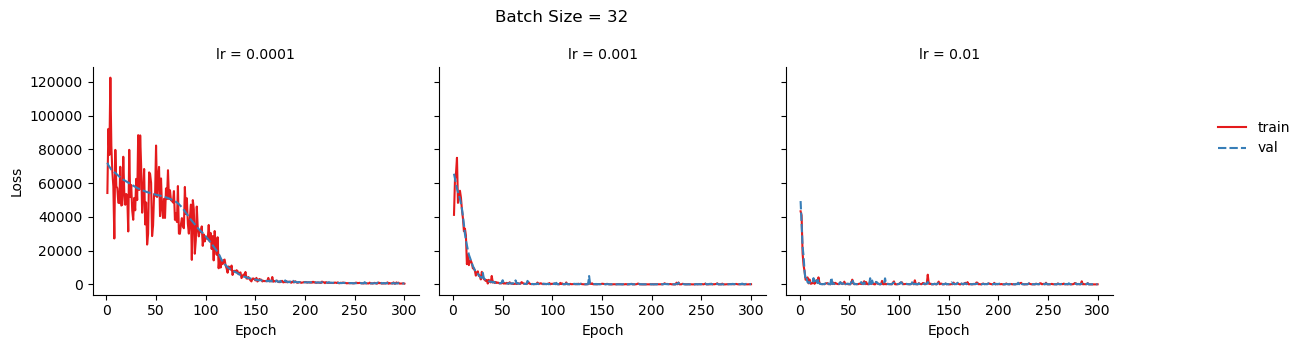

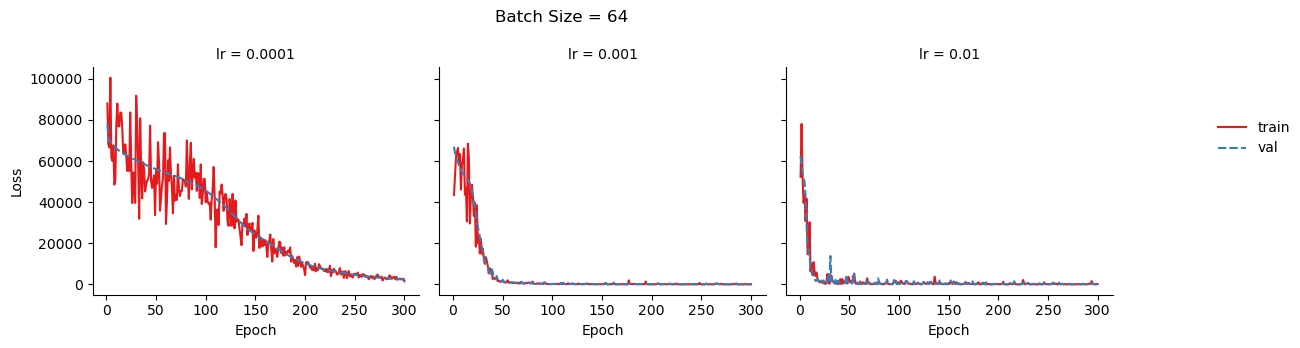

In [96]:
%matplotlib inline

#df = training 
df = validation
df = df_loss_long

df["linetype"] =  df["type"].apply(lambda x: "solid" if x == "train" else "dashed")
batch_size = [16,32,64]
lr = [0.01, 0.001, 0.0001, 0.1]
lrdecay = [0.01, 0.5, 0.001, 1.0]

if batch_size is not None:
    df = df[df['batch_size'].isin(batch_size)]
if lr is not None:
    df = df[df['lr'].isin(lr)]
if lrdecay is not None:
    df = df[df['lrdecay'].isin(lrdecay)]


# Loop over each unique batch size
for batch_size in sorted(df['batch_size'].unique()):
    tr_batch = df[df['batch_size'] == batch_size]

    g = sns.FacetGrid(tr_batch, col='lr', col_wrap=3, height=3.5, sharey=True)

    g.map_dataframe(
        sns.lineplot,
        x='epoch',
        y='loss',
        hue='type',
        palette='Set1',
        legend='brief',
        style="type",
    )

    g.set_axis_labels('Epoch', 'Loss')
    g.set_titles(col_template='lr = {col_name}')
    g.fig.subplots_adjust(top=0.85)  # leave space for main title
    g.fig.suptitle(f"Batch Size = {batch_size}", fontsize=12)

    # move legend outside
    g.add_legend()
    g._legend.set_bbox_to_anchor((1.15, 0.6))
    # y log
   
    plt.tight_layout()
    plt.show()


# Plot best combination of hyperparameters 

In [97]:
best_bs =32
best_lr = 0.001
best_decay = 1.0

loss_type = "train"


df_plot = df_centralized_training_loss[
    (df_centralized_training_loss['batch_size'] == best_bs) &
    (df_centralized_training_loss['lr'] == best_lr) &
    (df_centralized_training_loss['lrdecay'] == best_decay)
]
# combine lr, clipping and batch size into a single column
df_plot['lr_decay_bs'] = df_plot['lr'].astype(str) + "_" + df_plot['lrdecay'].astype(str) + "_" + df_plot['batch_size'].astype(str)


/var/folders/yx/rfhrpk093hz1gfwtn7qxt_180000gq/T/ipykernel_69136/2911256664.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['lr_decay_bs'] = df_plot['lr'].astype(str) + "_" + df_plot['lrdecay'].astype(str) + "_" + df_plot['batch_size'].astype(str)


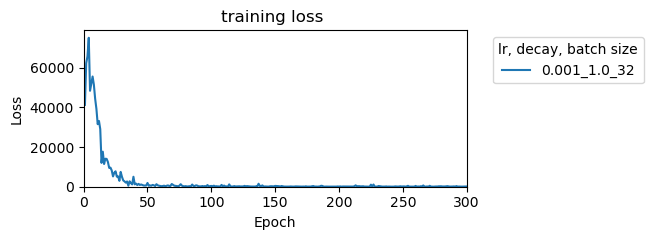

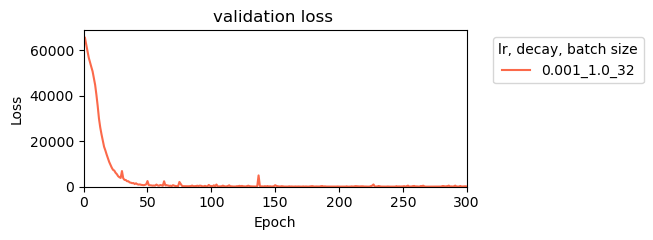

In [98]:
plt.figure(figsize=(5, 2.5))
reds = sns.color_palette("Reds", n_colors=1)
# # Plot training loss
sns.lineplot(
    data=df_plot,
    x='epoch',
    y='train_loss',
    hue='lr_decay_bs',
    palette='tab10'
)

plt.ylim(bottom=0)
plt.xlim(left=0, right=20)
plt.xticks(ticks=range(0, df['epoch'].max() + 1, 50))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('training loss ')
plt.tight_layout()
plt.legend(title="lr, decay, batch size", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# # Plot validation loss
plt.figure(figsize=(5, 2.5))
sns.lineplot(
    data=df_plot,
    x='epoch',
    y='val_loss',
    hue='lr_decay_bs',
    palette=reds,
    linestyle='-',
)

plt.ylim(bottom=0)
plt.xlim(left=0, right=20)
plt.xticks(ticks=range(0, df_plot['epoch'].max() + 1, 50))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('validation loss ')
plt.tight_layout()
plt.legend(title="lr, decay, batch size", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [99]:
# Get the min loss
min_train_loss = df_plot['train_loss'].min()
min_val_loss = df_plot['val_loss'].min()
print(f"Minimum training loss: {min_train_loss}")
print(f"Minimum validation loss: {min_val_loss}")

Minimum training loss: 26.781450271606445
Minimum validation loss: 39.2446644122784


In [100]:
#############################
# Load Dataset
#############################
test_dataset_filename = "../data/periodic_nonidd/periodic_nonidd_test.pt"
time_steps_filename = "../data/periodic_nonidd/periodic_nonidd_time_steps.pt"
timestamps = torch.load(time_steps_filename, weights_only=True)
dataset = torch.load(test_dataset_filename, weights_only=True)


# Load 



In [101]:
centralized_training_loss

['../results_noniid_centralized_fixed/periodic_nonidd/centralized_training/300_epochs/lr_0.0001-batchsize_64_clipping_False_lrdecay_1.0/loss_per_epoch.csv',
 '../results_noniid_centralized_fixed/periodic_nonidd/centralized_training/300_epochs/lr_0.001-batchsize_32_clipping_False_lrdecay_1.0/loss_per_epoch.csv',
 '../results_noniid_centralized_fixed/periodic_nonidd/centralized_training/300_epochs/lr_0.01-batchsize_64_clipping_False_lrdecay_1.0/loss_per_epoch.csv',
 '../results_noniid_centralized_fixed/periodic_nonidd/centralized_training/300_epochs/lr_0.0001-batchsize_32_clipping_False_lrdecay_1.0/loss_per_epoch.csv',
 '../results_noniid_centralized_fixed/periodic_nonidd/centralized_training/300_epochs/lr_0.001-batchsize_64_clipping_False_lrdecay_1.0/loss_per_epoch.csv',
 '../results_noniid_centralized_fixed/periodic_nonidd/centralized_training/300_epochs/lr_0.01-batchsize_32_clipping_False_lrdecay_1.0/loss_per_epoch.csv']

<Figure size 200x150 with 0 Axes>

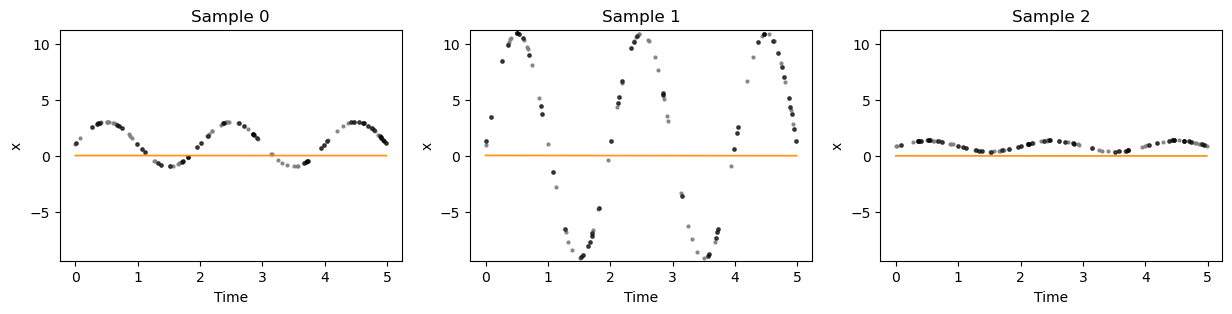

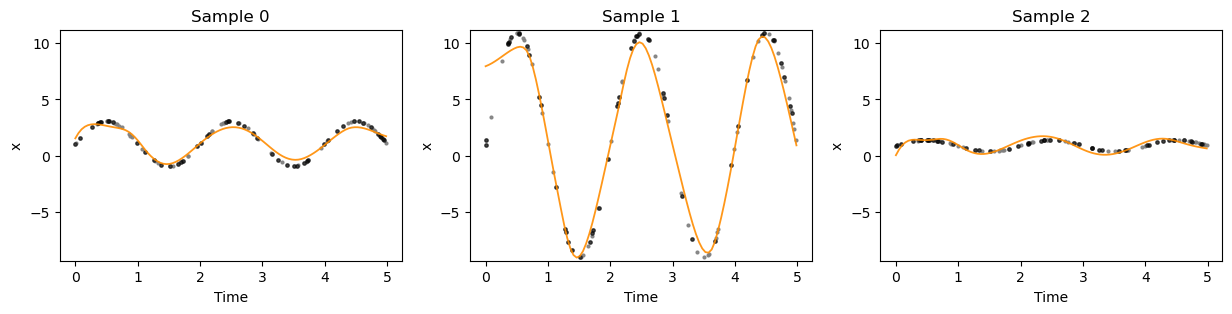

In [103]:
#############################
# Load Model and Weigths
#############################


weigths = "../results_noniid_centralized/periodic_nonidd/centralized_training/150_epochs/lr_0.001-batchsize_32_clipping_False_lrdecay_1.0/model.pth"
weigths = centralized_training_loss[0].replace("loss_per_epoch.csv", "model.pth")


model = Net()
plt.figure(figsize=(2, 1.5))
# before training
plot_n_outputs(model, dataset, timestamps, n = 3 )

# after 2 epochs
model.load_state_dict(torch.load(weigths, weights_only=True))
plot_n_outputs(model, dataset, timestamps, n = 3 )

